# Washington Double Star Catalogue Data Reduction

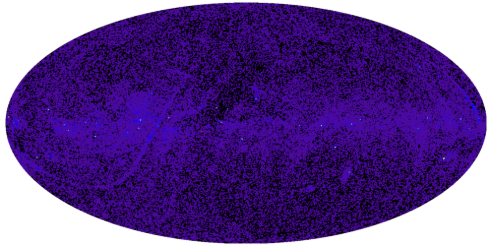

Imports a csv with "WDS" columns and constrains the data to physical constraint likelihood using proper motion and parallax. This assumes that magnitude and separation deltas have already been constrained.

In [229]:
#imports 

from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd
import numpy as np
import re

In [243]:
#load and read csv

file_path = "all-sky-constrained.csv" # constrained in Stelle Doppie with delta Mag < 3 and SEP 5 .. 10 arcmin
df = pd.read_csv(file_path) # create a dataframe in pandas

## Determine if proper motion infers physical co-motion

In astrometry, the proper motion of a star is its apparent angular motion across the sky, measured in milliarcseconds per year (mas/yr). Proper motion has two orthogonal components: Right Ascension (RA; α) and Declination (dec; δ). These components describe how the star moves east-west and north-south, respectively, on the celestial sphere.

The magnitude of the total proper motion is given by the magnitude of a vector formula in two-dimensions, using the proper motion components of α and δ:

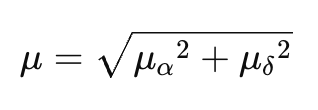

With this information we can also calculate the relative PM (rPM), a dimensionless ratio that compares the vector difference in motion to the total motion of the primary star, which quantifies the difference in their motions:

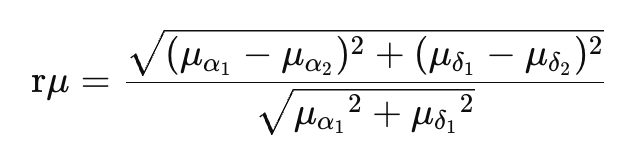

A rPM value that is less than 0.3 suggests that the double stars are co-moving and could be gravitationally bound.

In [231]:
# methods of proper motion

def calculate_proper_motion(ra, dec):
    if pd.isna(ra) or pd.isna(dec):
        return -1
    else:
        return np.sqrt(ra**2 + dec**2)

def calculate_relative_pm(pm1_ra, pm1_dec, pm2_ra, pm2_dec):
    if pd.isna(pm1_ra) or pd.isna(pm1_dec) or pd.isna(pm2_ra) or pd.isna(pm2_dec):
        return -1
    else:
        numerator = np.sqrt((pm1_ra - pm2_ra)**2 + (pm1_dec - pm2_dec)**2)
        denominator = np.sqrt(pm1_ra**2 + pm1_dec**2)
    
        if denominator == 0:
            return -1
        else:
            return numerator/denominator

In [245]:
# loop through the data frame and remove rows with rPM values over 0.3

for idx, row in df.iterrows():
    """
    Calculates the PM and rPM from WDS.

    If the rPM indicates proper motion or we cannot calculate the rPM, 
    we keep the row.
    """
    rpm = calculate_relative_pm(row["pm1_ra"], row["pm1_dec"], row["pm2_ra"], row["pm2_dec"])
    
    df.at[idx, "pm1"] = calculate_proper_motion(row["pm1_ra"], row["pm1_dec"])
    df.at[idx, "pm2"] = calculate_proper_motion(row["pm2_ra"], row["pm2_dec"])
    df.at[idx, "rPM"] = rpm

    if rpm > 0.3: # drop rows that don't meet our constraint
        df = df.drop(idx)
        
    # add deltas of magnitude and separation to dataframe
    df["delta_mag"] = abs(row["mag1"] - row["mag2"])
    df["delta_sep"] = abs(row["sep_first"] - row["sep_last"])


## Querying GAIA DR3

### Using Vizier

We use [Vizier](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/355/gaiadr3) within astroquery to find the double stars from WDS. We do this using the region centered around the celestial coordinates with a radius of 2 arcminutes. 

We capture the source column which can be used to access the object directly in Vizier with a constraint search:
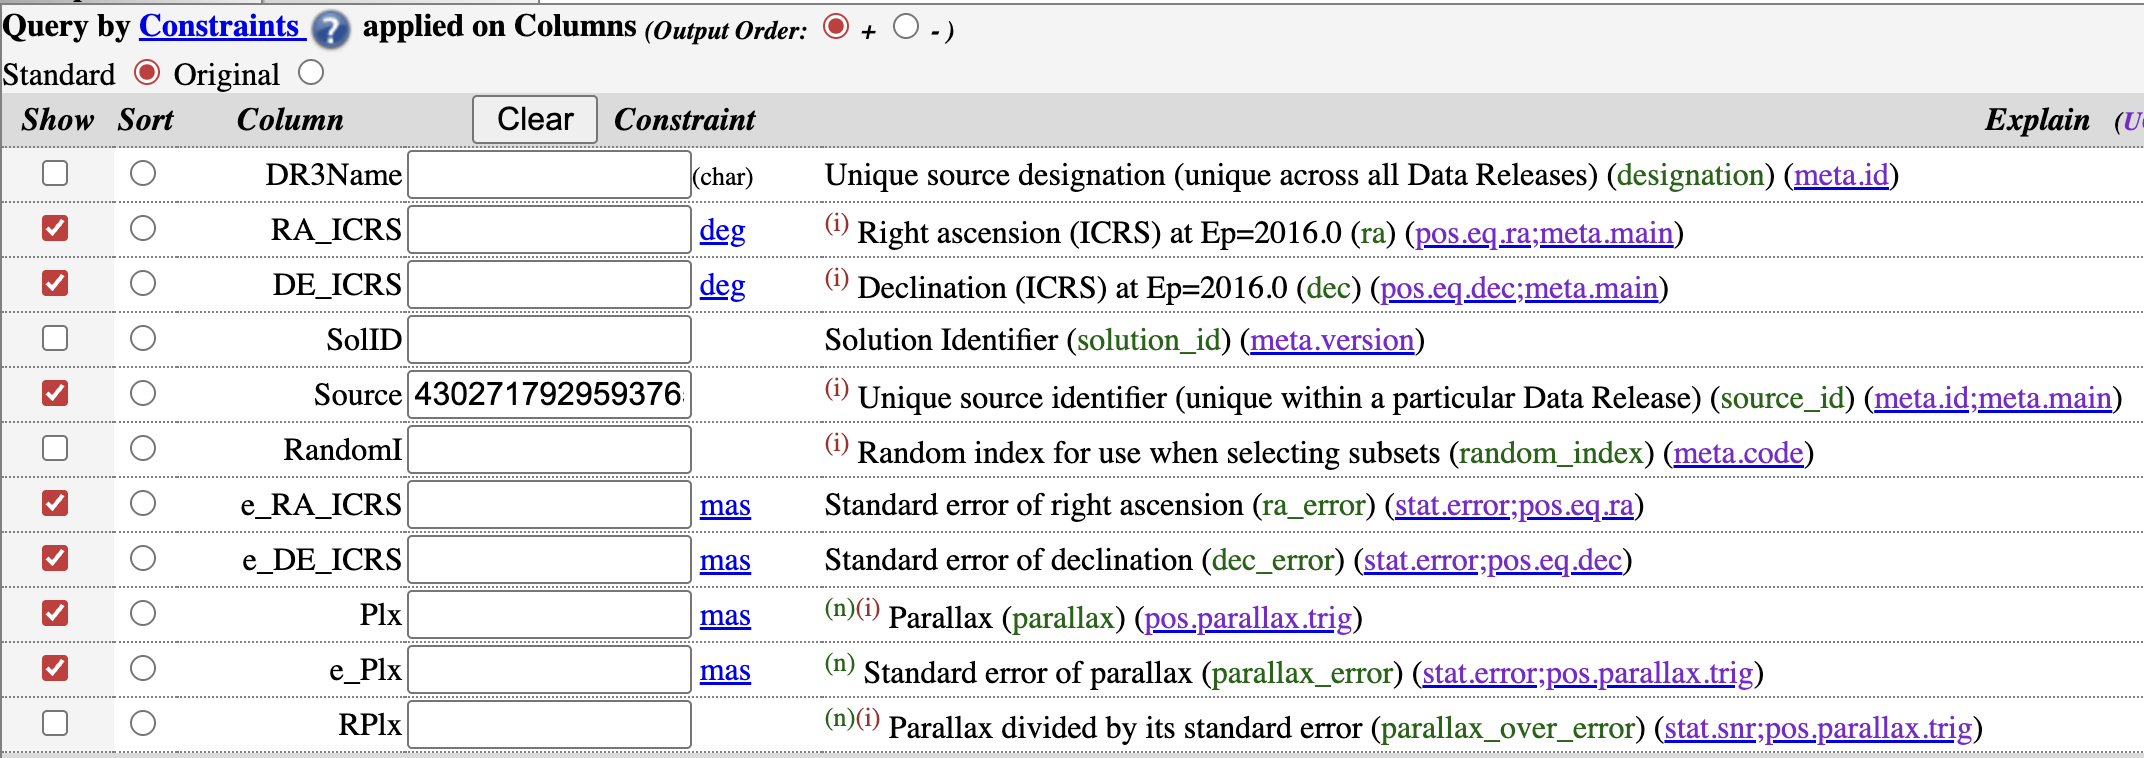

The celestial coordinates in the data from WDS use a compact decimal sexagesimal format that must be converted in order for the platform to understand the request.

In [246]:
# methods for GAIA query

def clamp_sexagesimal(val, upper=60.0):
    """Ensure val is < upper to avoid overflows in SkyCoord."""
    try:
        v = float(val)
        if v >= upper:
            v = upper - 1e-6  # prevent overflow
        return f"{v:.6f}".rstrip('0').rstrip('.')
    except ValueError:
        return val
    
def parse_coord(coord_str):
    """
    Parses concatenated decimal sexagesimal format into a SkyCoord object.
    """
    # Split on first + or -
    match = re.match(r"^([0-9.]+)([+-][0-9.]+)$", coord_str)
    if not match:
        raise ValueError(f"Invalid coordinate string: {coord_str}")

    ra_raw, dec_raw = match.groups()

    # Convert RA from hhmmss.ss to hms
    ra_h = ra_raw[0:2]
    ra_m = clamp_sexagesimal(ra_raw[2:4])
    ra_s = clamp_sexagesimal(ra_raw[4:])

    # Convert Dec from ddmmss.s to dms
    dec_sign = dec_raw[0]
    dec_d = dec_raw[1:3]
    dec_m = clamp_sexagesimal(dec_raw[3:5])
    dec_s = clamp_sexagesimal(dec_raw[5:])

    ra_str = f"{ra_h}h{ra_m}m{ra_s}s"
    dec_str = f"{dec_sign}{dec_d}d{dec_m}m{dec_s}s"

    return SkyCoord(ra=ra_str, dec=dec_str, frame="icrs")

Vizier will also truncate results that contain more than 50 stars. By limiting the results based on our constrained magnitudes (less than 14), we can avoid the stars we are looking for from being left out the results.

## Using parallax as a constraint

We can further narrow candidates with parallax. Parallax is the apparent shift in position of a nearby star against the background of distant stars, caused by Earth's motion around the Sun. This shift is measured in milliarcseconds (mas).

The parallax angle 𝑝 is inversely proportional to the star's distance:

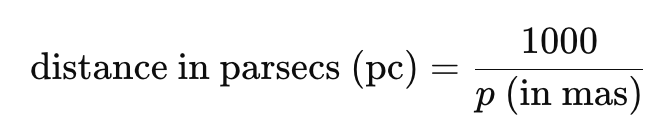

We use the parallax values of two stars to compute their the **minimum radial separation** between the stars. 

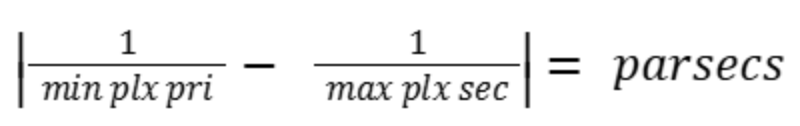

This helps further constrain physically associated stellar pairs by comparing how far apart they are in 3D space, not just in angular coordinates. Typical binaries are between 0.1 and 10,000 AU apart, while wide binaries can have as much as 100,000 AU between them. Tight binaries are separated by less than 0.1 AU, and edge cases may push constraints up to 200,000 AU.

In [247]:
# methods for pair finding

def find_closest_parallax_pair(plx_values):
    """
    Find the pair of indices in `plx_values` with the minimum absolute parallax difference.
    """
    min_delta_parallax = float("inf")
    best_pair = (None, None)

    if len(plx_values) > 1:
        for j in range(len(plx_values)):
            for k in range(j + 1, len(plx_values)):
                delta = abs(plx_values[j] - plx_values[k])
                if delta < min_delta_parallax:
                    min_delta_parallax = delta
                    best_pair = (j, k)

    return best_pair

def is_pm_match(star, wds_pm, threshold=30):
    dra = star["pmRA"] - wds_pm[0]
    ddec = star["pmDE"] - wds_pm[1]
    return np.hypot(dra, ddec) < threshold

def is_mag_match(gmag, wds_mag, tolerance=1.0):
    return abs(gmag - wds_mag) < tolerance

In [251]:
# loop through dataframe and query GAIA

Vizier.columns = ["Source", "Plx", "e_Plx", "Gmag", "pmRA", "pmDE"] # columns of interest

skipped = []

columns_to_add = [
    "pri_source", "sec_source",
    "pri_plx", "sec_plx", "pri_e_plx", "sec_e_plx",
    "pri_gaia_gmag", "sec_gaia_gmag",
    "pri_gaia_pmra", "pri_gaia_pmdec",
    "sec_gaia_pmra", "sec_gaia_pmdec",
    "min_rad_sep_pc", "min_rad_sep_au", "min_rad_sep_ly"
]

for col in columns_to_add:
    df[col] = np.nan
    
df["pri_source"] = None
df["sec_source"] = None

for idx, row in df.iterrows():
    try:
        wds_id = row["wds_id"]
        coord = parse_coord(row["coord_arcsec_2000"])
        result = Vizier.query_region(coord, radius=2 * u.arcmin, catalog="I/355/gaiadr3", column_filters={'Gmag': '<14'})

        if result:
            filtered_indices = []
            best_pair = (None, None)
                    
            # filter by proper motion and magnitude values
            for i, star in enumerate(result[0]):
                if is_mag_match(star["Gmag"], row["mag1"]) or is_mag_match(star["Gmag"], row["mag2"]):
                    if is_pm_match(star, [row["pm1_ra"], row["pm1_dec"]]) or is_pm_match(star, [row["pm2_ra"], row["pm2_dec"]]):
                        filtered_indices.append(i)
                        
            # filter by best parallax proximity
            if len(filtered_indices) >= 2:
                min_delta_parallax = float("inf")
    
                plx_values = np.array([result[0][i]["Plx"] for i in filtered_indices])  # Access parallax values as array
                
                if len(plx_values) > 1:
                    best_pair = find_closest_parallax_pair(plx_values)
                else:
                    skipped.append(wds_id)
                
            else:
                skipped.append(wds_id)
                
            # Calculate minimum radial separation
            if best_pair[0] is not None and best_pair[1] is not None:
                p1 = result[0][filtered_indices[best_pair[0]]]
                p2 = result[0][filtered_indices[best_pair[1]]]
                
                # the brighter star is the primary star
                if (p1["Gmag"] > p2["Gmag"]): 
                    old_p2 = p2
                    p2 = p1
                    p1 = old_p2
            
                # Convert each parallax to distance in parsecs
                d1_pc = 1000 / (p1["Plx"] + p1["e_Plx"])
                d2_pc = 1000 / (p2["Plx"] - p2["e_Plx"])
            
                # Compute radial (line-of-sight) separation in parsecs
                radial_sep_pc = abs(d1_pc - d2_pc)
            
                # Convert to AU and light-years
                radial_sep_au = radial_sep_pc * u.pc.to(u.au)
                radial_sep_ly = radial_sep_pc * u.pc.to(u.lyr)
                
                """
                If the minimum radial seperation indicates possible physical binary or 
                we cannot calculate the minimum radial seperation, we keep the row.
                """
                df.at[idx, "pri_source"] = p1["Source"]
                df.at[idx, "sec_source"] = p2["Source"]
                df.at[idx, "pri_plx"] = p1["Plx"]
                df.at[idx, "sec_plx"] = p2["Plx"]
                df.at[idx, "pri_e_plx"] = p1["e_Plx"]
                df.at[idx, "sec_e_plx"] = p2["e_Plx"]
                df.at[idx, "pri_gaia_gmag"] = p1["Gmag"]
                df.at[idx, "sec_gaia_gmag"] = p2["Gmag"]
                df.at[idx, "pri_gaia_pmra"] = p1["pmRA"]
                df.at[idx, "pri_gaia_pmdec"] = p1["pmDE"]
                df.at[idx, "sec_gaia_pmra"] = p2["pmRA"]
                df.at[idx, "sec_gaia_pmdec"] = p2["pmDE"]
                df.at[idx, "min_rad_sep_pc"] = radial_sep_pc
                df.at[idx, "min_rad_sep_au"] = radial_sep_au
                df.at[idx, "min_rad_sep_ly"] = radial_sep_ly

                # drop rows that don't meet our constraint
                if radial_sep_au > 100000:
                    df = df.drop(idx)
                    
    except Exception as e:
        print(f"Error for {row["wds_id"]}: {e}")
        
df = df.sort_values(by="min_rad_sep_au", ascending=True)
df.to_csv("constrained-double-stars.csv", index=False)

print(f"{len(df)} results saved to: constrained-double-stars.csv")
print(f"Not enough GAIA sources with valid parallax to compute separation for {len(skipped)} doubles.")

470 results saved to: constrained-double-stars.csv
Not enough GAIA sources with valid parallax to compute separation for 275 doubles.
